## **Importing Required Packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dropout, Dense, Flatten, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Conv2D, MaxPool2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception

import cv2

from tqdm import tqdm
import os
import gc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings("ignore")

## **Loading Data**

In [2]:
test_directory = "../input/non-and-biodegradable-waste-dataset/TEST"
train_directory = "../input/non-and-biodegradable-waste-dataset/TRAIN.1"
# validation_directory = "../input/placenta-cell-data/PlacentaCell/validation"

In [3]:
img_size = (60,60)

In [4]:
def load_data(directory,img_size):
    images = []
    labels = []
    
    for i in tqdm(os.listdir(directory)):
        
        if i == 'B': label = 0
        elif i == 'N': label = 1
            
        for j in os.listdir(directory + '/' + i):
            
            image = cv2.imread(directory + '/' + i + '/' + j)
            resized_img = cv2.resize(image,img_size)
            
            images.append(resized_img / 255.0)
            labels.append(label)
            
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')
    
    return images, labels

In [5]:
test_images, test_labels = load_data(test_directory,img_size)
train_images, train_labels = load_data(train_directory,img_size)
# val_images, val_labels = load_data(validation_directory,img_size)

100%|██████████| 2/2 [06:45<00:00, 202.83s/it]


In [6]:
print(f'Shape of Test Data : {np.shape(test_images)} & Shape of Test Labels : {np.shape(test_labels)}')
print(f'Shape of Train Data : {np.shape(train_images)} & Shape of Train Label : {np.shape(train_labels)}')
# print(f'Shape of Validation Data : {np.shape(val_images)} & Shape of Validation Label : {np.shape(val_labels)}')

Shape of Test Data : (16726, 60, 60, 3) & Shape of Test Labels : (16726,)
Shape of Train Data : (59922, 60, 60, 3) & Shape of Train Label : (59922,)


## **Data Visualization**

### **Sample image from train data**

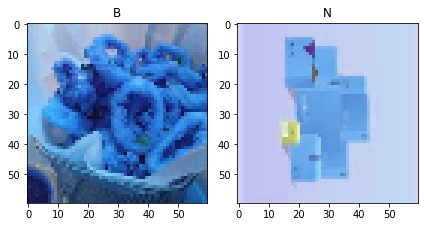

In [7]:
class_names = ['B','N']
fig, axes = plt.subplots(1,len(class_names))

for i in range(len(class_names)):
    dir_path = "../input/non-and-biodegradable-waste-dataset/TRAIN.1" + '/' + class_names[i]
    img_path = dir_path + '/' + os.listdir(dir_path)[2]
    img = cv2.imread(img_path)
    resized_img = cv2.resize(img,img_size)
    axes[i].imshow(resized_img)
    axes[i].set_title(class_names[i])
    plt.tight_layout()

plt.show()

### **Class Distribution**

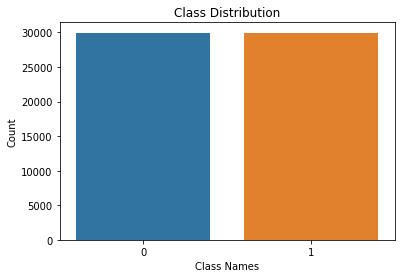

In [8]:
sns.countplot(x = train_labels)
plt.title("Class Distribution")
plt.xlabel("Class Names")
plt.ylabel("Count")
plt.show()

## **VGG16**

In [9]:
vgg16_model = Sequential()

vgg16_base = VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape = (60,60,3),
    pooling = 'max'
)

print(f"Number of layers in Inception: {len(vgg16_base.layers)}")

for layer in vgg16_base.layers[:]:
    layer.trainable = False
    
for layer in vgg16_base.layers[16:]:
    layer.trainable = True
    
vgg16_model.add(vgg16_base)

vgg16_model.add(Flatten())

vgg16_model.add(Dense(units = 5, activation = 'softmax'))

vgg16_model.summary()

early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 20,restore_best_weights = True,verbose = 0)

vgg16_model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.001) , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

vgg16 = vgg16_model.fit(train_images, train_labels, batch_size = 32, epochs = 20, callbacks = [early_stopping])

58900480/58889256 [==============================] - 1s 0us/step
Number of layers in Inception: 20
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 4,722,181
Non-trainable params: 9,995,072
_________________________________________________________________
Epoch 1/20
1873/1873 [==============================] - 48s 19ms/step - loss: 0.2583 - accuracy: 0.9202
Epoch 2/20
1873/1873 [==============================] - 36s 19ms/step - loss: 0.1668 - accuracy: 0.9437
Epoch 3/20
1873/1873 [==============================] - 37s 

In [10]:
vgg16_predictions = vgg16_model.predict(test_images)
vgg16_predictions = np.argmax(vgg16_predictions,axis = 1)

In [11]:
vgg16_accuracy = vgg16_model.evaluate(test_images, test_labels, verbose = 0) 
print('Test accuracy:', vgg16_accuracy[1])

Test accuracy: 0.8880784511566162


## **Evaluation**

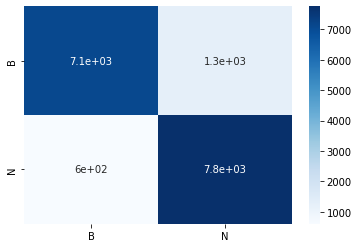

In [12]:
cm = confusion_matrix(test_labels, vgg16_predictions)
sns.heatmap(cm,cmap = 'Blues',annot = True, xticklabels = class_names, yticklabels = class_names)
plt.show()

## **Classification Report ( Precision , recall , F1 Score )**

In [13]:
def scores(cm):
    p = {}
    r = {}
    f1 = {}
    
    for i in range(len(cm)):
        p[i] = cm[i,i] / sum(cm[:,i])
        r[i] = cm[i,i] / sum(cm[i,:])
        f1[i] = 2 * (cm[i,i] / sum(cm[:,i])) * (cm[i,i]/sum(cm[i,:])) / ((cm[i,i] / sum(cm[:,i])) + (cm[i,i]/sum(cm[i,:])))
    
    return p,r,f1    

In [14]:
precision, recall, f1_score = scores(cm)

In [15]:
Evaluation = {
    'Precision' : precision,
    'Recall' : recall,
    'F1 Score' : f1_score
}

Result = pd.DataFrame(Evaluation)

Result

,Precision,Recall,F1 Score
0,0.921767,0.848141,0.883423
1,0.859373,0.928016,0.892377
